In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

import string
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

In [12]:
def get_unique_words(text):
    words = [word for message in text for word in message]
    return set(words)

def co_occurence_matrix_with_window(text, window_size, stop_words):
    '''
    Calculates the co-occurence matrix using a sliding window of size window_size as context    
    Output is (unique) words x (unique) words
    '''
    unique_words = get_unique_words(text)
    n = len(unique_words) #number of unique words
    co_matrix = pd.DataFrame(data=np.zeros([n,n]), columns=unique_words, index=unique_words, dtype='int')

    #for each word in each message, counts +1 for each pair [word,context]
    for message in text:
        msg_len = len(message)
        for i, word in enumerate(message):
            first = max(i - window_size, 0)
            last = min(i + window_size + 1, msg_len)
            for context in message[first:last]:
                co_matrix.loc[word,context] += 1
    return co_matrix  
    
def word_occurence_matrix(text, target=None, stop_words=None, binary=True, preprocess_text=False):  
    '''
    Output is messages x (unique) words
    
    If binary=True, then each element represents if the word is in the message or not.
    Otherwise, it represents the count of how many times that word appears in that message.
    ''' 
    if target:
        text = list(filter(lambda x : target in x, text)) #Filter comments in which target word is present
        
    preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor()   
    if stop_words:        
        stop_words = [preprocessor(word) for word in stop_words] #preprocesses stop words
    if preprocess_text:
        text = [preprocessor(msg) for msg in text] #preprocesses text
        
    #calculates word count for each message
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, binary=binary)
    X = vectorizer.fit_transform(text).toarray()
    
    labels = vectorizer.get_feature_names()
    
    return X, labels

def co_occurence_matrix(word_occurence_matrix):
    '''
    Co-occurence matrix created based on the word count/occurence matrix.     
    In other words, this co-occurence matrix will consider each message as the context for all words in it.
    '''
    co_X = word_occurence_matrix.T @ word_occurence_matrix
    np.fill_diagonal(co_X, 0)
    return co_X

def score_ngrams(text, freq_filter=1, score_metric=BigramAssocMeasures().pmi):
    '''
    Score n-grams using score_metric. Defaults to PMI.
    '''
    words = [word.strip(string.punctuation) for message in text 
                                            for word in message.lower().split()]
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(freq_filter)
    return finder.score_ngrams(score_metric)

### Load data

In [11]:
comments = pd.read_csv('../comentarios_sorted_votes.csv')

preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor()
comments['text'] = [preprocessor(msg) for msg in comments['text']]
text = comments['text'].dropna()

stop_words = [word.rstrip() for word in open('stopwords.txt')]
N = 30 #Consider only the N most frequent words

### 1. Co-ocorrência 

Considerações:
- O contexto considerado para computar a co-ocorrência foram os comentários. Para restringir a uma janela de tamanho fixo, usar `co_occurence_matrix_with_window()`;
- ~66k comentários e ~47k palavras únicas. Não dá para gerar a matriz completa de palavras por comentários;
- Usei os primeiros 20k comentários por simplicidade, mas o melhor seria filtrar os comentários por aqueles que contém pelo menos uma das k palavras mais frequentes (o que envolve uma tarefa feita pelo Gabriel. Não tive acesso ao que ele desenvolveu ainda, mas vou falar com ele);
- Faltam muitas palavras na lista de stop words;

#### 1.1. Co-cocorrência com uma palavra pré-definida

In [4]:
target='virus'

X, labels = word_occurence_matrix(text, target=target, stop_words=stop_words)

word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
word_count = sorted(zip(labels, word_count), reverse=True, key=lambda tupl : tupl[1])
print(f'{N} palavras que mais ocorrem nos mesmos comentários em que "{target}" ocorre:\n')
print(word_count[:N])

30 palavras que mais ocorrem nos mesmos comentários em que "virus" ocorre:

[('virus', 692), ('coronavirus', 632), ('corona', 164), ('dias', 154), ('pessoas', 154), ('pra', 154), ('dr', 152), ('https', 146), ('pode', 140), ('ivermectina', 136), ('sintomas', 128), ('agora', 126), ('sobre', 124), ('todos', 123), ('ainda', 122), ('covid', 115), ('vai', 115), ('video', 104), ('dia', 95), ('cura', 93), ('bem', 91), ('casa', 91), ('medico', 91), ('saude', 90), ('drauzio', 89), ('vc', 89), ('19', 88), ('brasil', 86), ('deus', 86), ('falta', 84)]


#### 1.2. Co-ocorrência "geral"

In [6]:
#Using text[:17000] bc text is too big. It would be better to use a subset of comments based on most the freq words
X, labels = word_occurence_matrix(text[:17000], stop_words=stop_words)

#Selects only the N most frequent words. Otherwise, co_X would be giant
word_count = X.sum(axis=0)
most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
word_count, labels, X_t = zip(*most_freq_zipped)

X = np.vstack(X_t).T #After unzip, X_t is (words x comments)
co_X = co_occurence_matrix(X)

In [7]:
print(f'Selecionando as {N} palavras que mais ocorrem:\n')
print(list(zip(labels, word_count)))

30 palavras que mais ocorrem:
[('dias', 2269), ('deus', 1843), ('pra', 1762), ('dr', 1654), ('dia', 1218), ('covid', 1215), ('ivermectina', 1202), ('virus', 1147), ('vai', 1123), ('bem', 1122), ('pessoas', 1102), ('agora', 1090), ('todos', 1061), ('vc', 1028), ('sintomas', 995), ('video', 987), ('drauzio', 944), ('ainda', 930), ('tudo', 923), ('olfato', 922), ('nada', 910), ('assim', 906), ('pode', 871), ('medico', 871), ('paladar', 866), ('tomar', 808), ('fazer', 778), ('bom', 777), ('casa', 766), ('aqui', 711)]


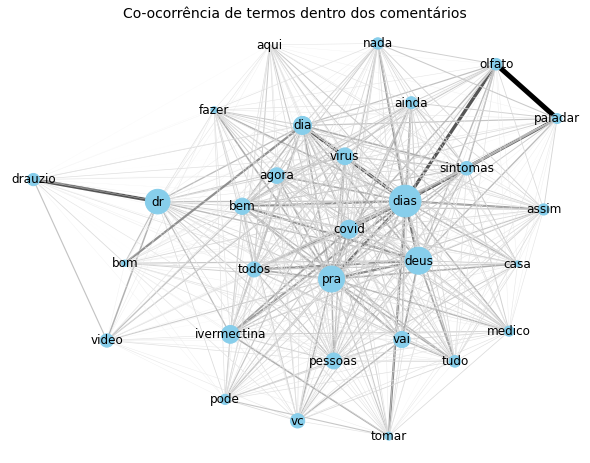

In [12]:
G = nx.Graph()

for i, row in enumerate(co_X):
    for j, co in enumerate(co_X[i]):
        G.add_edge(labels[i], labels[j], weight=(co))
        
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5, 
        edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
        pos = nx.spring_layout(G, k=1))
plt.title('Co-ocorrência de termos dentro dos comentários', fontsize=14)
plt.show()

### 2. N-gramas

Considerações:

- PMI - favorece n-gramas raros. Muitos n-gramas com a mesma score (a mais alta)

#### Frequência bruta

In [14]:
freq = BigramAssocMeasures().raw_freq
print(f'{N} bigramas mais frequentes')
score_ngrams(text, score_metric=freq, freq_filter=3)[:N]

30 bigramas mais frequentes


[(('e', 'o'), 0.002094087760614864),
 (('o', 'que'), 0.0018388988663329549),
 (('que', 'nao'), 0.001554856956365905),
 (('que', 'o'), 0.0014933038562376052),
 (('e', 'a'), 0.001429827221730296),
 (('e', 'nao'), 0.0012406796744610417),
 (('falta', 'de'), 0.001183614821217097),
 (('o', 'virus'), 0.0011784853962064055),
 (('olfato', 'e'), 0.001121420542962461),
 (('nao', 'e'), 0.0011188558304571152),
 (('e', 'um'), 0.0010406320990440675),
 (('que', 'a'), 0.0010399909209177311),
 (('a', 'deus'), 0.001027167358391002),
 (('em', 'casa'), 0.0010265261802646654),
 (('com', 'o'), 0.0009995966989585344),
 (('com', 'a'), 0.0009681789707680481),
 (('que', 'e'), 0.000917525898787468),
 (('dor', 'de'), 0.0009027788018817296),
 (('de', 'ar'), 0.0008854669924706453),
 (('e', 'paladar'), 0.0008694375393122339),
 (('estou', 'com'), 0.000868155183059561),
 (('3', 'dias'), 0.0008309668517320466),
 (('nao', 'tem'), 0.0008290433173530372),
 (('a', 'ivermectina'), 0.0008264786048476913),
 (('de', 'cabeca'), 

#### PMI

In [15]:
pmi = BigramAssocMeasures().pmi
score_ngrams(text, score_metric=pmi, freq_filter=30)[:N]

[(('democraticos', 'solidarios'), 15.528377335773902),
 (('solidarios', '📖'), 15.305984914437454),
 (('global>watsapp>+351969602263', 'valdemir'), 14.844851000569156),
 (('valdemir', '🇧🇷🇧🇷🇧🇷🇵🇹🙏'), 14.844851000569156),
 (('invisivel', '🙏🇧🇷🇵🇹passando'), 14.7914117416077),
 (('macgyver', 'global>watsapp>+351969602263'), 14.572771455132356),
 (('pet', 'shops'), 14.500621669376523),
 (('joaquim', 'inacio'), 14.488494544600869),
 (('sonia', '🕊'), 14.485308613882019),
 (('albert', 'dickson'), 14.091328141880618),
 (('inimigo', 'invisivel'), 14.016971442022829),
 (('botao', 'alerta'), 13.971507142082102),
 (('evite', 'roubos'), 13.926294565198498),
 (('carol', 'bandeira'), 13.887761777560874),
 (('bla', 'bla'), 13.885587833693535),
 (('31', '98200-1348'), 13.81788395296889),
 (('lojas', 'agropecuarias'), 13.775440784695913),
 (('atila', 'iamarino'), 13.74909201776373),
 (('hs', 'debaixo'), 13.664973789364508),
 (('➨', 'compartilhe'), 13.618575144745483),
 (('insta', 'fonothaisprett'), 13.51715

#### likelihood ratio

In [16]:
lr = BigramAssocMeasures().likelihood_ratio
score_ngrams(text, score_metric=lr, freq_filter=3)[:N]

[(('em', 'casa'), 11872.705126378965),
 (('falta', 'de'), 11753.081633881198),
 (('dra', 'lucy'), 10629.36403851711),
 (('dr', 'drauzio'), 10553.526149800462),
 (('15', 'dias'), 9145.38518784183),
 (('3', 'dias'), 8956.600991339685),
 (('gracas', 'a'), 8533.35231393537),
 (('as', 'pessoas'), 8312.294168667986),
 (('lucy', 'kerr'), 8311.112071413721),
 (('de', 'ar'), 7950.062437092549),
 (('o', 'virus'), 7670.37302836852),
 (('sem', 'sentir'), 7647.323199711086),
 (('por', 'favor'), 7630.875433149813),
 (('um', 'pouco'), 7328.726172283474),
 (('o', 'senhor'), 7185.744945317093),
 (('de', 'cabeca'), 7125.34908240446),
 (('todos', 'os'), 7054.034324722953),
 (('boa', 'noite'), 6667.68597512089),
 (('sentir', 'cheiro'), 6631.817715655884),
 (('covid', '19'), 6338.290338619572),
 (('olfato', 'e'), 6229.263023189648),
 (('dor', 'de'), 5913.495936065046),
 (('corona', 'virus'), 5705.349368248605),
 (('sem', 'olfato'), 5359.130159982324),
 (('pode', 'ser'), 5345.396511045704),
 (('os', 'sintom

### 3. Variação da frequência entre os canais 

Considerações:
- "Frequência relativa" me remete a ter uma "base" sobre a qual computar a métrica, mas, como isso não ficou claro, usei o exemplo do card ('casa' e 'vacina') e fiz algo que me daria as palavras cuja frequência mais varia entre os canais.

In [17]:
comments_by_channel = []
for _, group in comments.groupby('uploader_id'):
    channel_comments = ' '.join(group['text'])
    comments_by_channel.append(channel_comments)

In [18]:
X, labels = word_occurence_matrix(comments_by_channel, stop_words=stop_words, binary=False)

#Selects only the N with higher std
word_std = X.std(axis=0)
higher_std_zipped = sorted(zip(word_std, labels, X.T), reverse=True)[:N]
word_std, labels, X_t = zip(*higher_std_zipped)

word_std_i = ['%.2f'%(x) for x in word_std]
print(f'{N} palavras com maior desvio padrão entre os canais:\n')
print(list(zip(labels, word_std_i)))

30 palavras com maior desvio padrão entre os canais:

[('dias', '1455.78'), ('pra', '1049.82'), ('cheiro', '1042.45'), ('olfato', '1027.02'), ('paladar', '1001.82'), ('drauzio', '998.49'), ('deus', '991.67'), ('dr', '789.28'), ('vc', '780.15'), ('virus', '775.28'), ('dor', '774.94'), ('video', '756.05'), ('vai', '715.52'), ('pessoas', '667.18'), ('ivermectina', '662.84'), ('sinto', '658.18'), ('sentir', '652.27'), ('nada', '646.07'), ('gosto', '641.44'), ('to', '640.35'), ('dia', '616.81'), ('assim', '616.09'), ('sintomas', '600.67'), ('agora', '560.24'), ('covid', '544.26'), ('bem', '528.45'), ('ainda', '509.48'), ('casa', '488.31'), ('ta', '479.48'), ('tudo', '453.04')]
